# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json

import coco
import utils
import model_visualization as modellib
import visualize
from config import Config
from pycocotools import mask as maskUtils



%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "cityscape_data20180203T2055/mask_rcnn_cityscape_data_0020.h5")
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/home/xiao/.conda/envs/dl4cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class CityscapeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscape_data"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes
    NUM_CLASSES = 35

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 2048
#     IMAGE_MIN_DIM = 512
#     IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200  # default value

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100  # small number on small dataset, better smaller than 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5  # bigger number improves validation stats accuracy but slows down

In [3]:
class InferenceConfig(CityscapeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[512 512]
 [256 256]
 [128 128]
 [ 64  64]
 [ 32  32]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscape_data
NUM_CLASSES                    35
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TR

## Create Model and Load Trained Weights

In [4]:
COCO_MODEL_PATH

'/home/xiao/shangyin/WWGH/logs/cityscape_data20180202T1908/mask_rcnn_cityscape_data_0010.h5'

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

## cityscape class

In [5]:
class_names = [
        'unlabeled',
        'ego vehicle',  
        'rectification border',
        'out of roi',          
        'static',              
        'dynamic',              
        'ground',         
        'road',              
        'sidewalk',             
        'parking',              
        'rail track',        
        'building',       
        'wall',           
        'fence',      
        'guard rail',
        'bridge',             
        'tunnel',            
        'pole',              
        'polegroup',         
        'traffic light',     
        'traffic sign',       
        'vegetation',           
        'terrain',              
        'sky',                  
        'person',               
        'rider',                
        'car',                 
        'truck',              
        'bus',                
        'caravan',             
        'trailer',           
        'train',            
        'motorcycle',         
        'bicycle',             
        'license plate']

## display ground truth

In [6]:
CITY_DIR = "../cityscapes-dataset/"

class CityscapesDataset(utils.Dataset):    
    def load_cityscapes(self, dataset_dir, subset):
        """Load a subset of the cityscapes dataset.
        dataset_dir: The root directory of the cityscapes dataset.
        subset: What to load (train, val, test)
        """
        self.class_labels = {
        'unlabeled':0,
        'ego vehicle':1,        
        'rectification border':2,
        'out of roi':3,           
        'static':4,               
        'dynamic':5,              
        'ground':6,               
        'road':7,                 
        'sidewalk':8,             
        'parking':9,              
        'rail track':10,           
        'building':11,            
        'wall':12,                 
        'fence':13,                
        'guard rail':14,           
        'bridge':15,               
        'tunnel':16,               
        'pole':17,                 
        'polegroup':18,            
        'traffic light':19,        
        'traffic sign':20,         
        'vegetation':21,           
        'terrain':22,              
        'sky':23,                  
        'person':24,               
        'rider':25,                
        'car':26,                  
        'truck':27,                
        'bus':28,                  
        'caravan':29,              
        'trailer':30,              
        'train':31,                
        'motorcycle':32,           
        'bicycle':33,              
        'license plate':34}

#         image_dir = "{}/{}/{}".format(dataset_dir, "images", subset)
#         annotation_dir = "{}/{}/{}".format(dataset_dir, "annotations", subset)
        
        annotation_dir = dataset_dir + 'gtFine_trainvaltest/' + subset + '_all.json'
        self.image_info = json.load(open(annotation_dir, 'r'))
        
        self.image_info = self.image_info[:10]



        # All images within the folder
#         num_images = len(glob.glob('*'))
#         image_ids = range(num_images)
        
        # Add classes
        for i in range(len(self.class_labels)):
            self.add_class("cityscape", i, list(self.class_labels.keys())[i])
            
        # Add images
#         for i in image_ids:
#             self.add_image(
#                 # "cityscapes", 
#                 image_id=i,
#                 # path=os.path.join(image_dir, coco.imgs[i]['file_name']),
#                 width=coco.imgs[i]["width"],
#                 height=coco.imgs[i]["height"],
#                 annotations=coco.loadAnns(coco.getAnnIds(
#                     imgIds=[i], catIds=class_ids, iscrowd=None)))
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        pass
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # TODO: build dict **self.image_info** in this form
        # self.image_info.keys() = ['objects', 'imgWidth', 'imgHeight']
        # objects is a list which contains label and polygon (same as annotations form below)
        # imgHeight and imgWidth are numbers (usually 1024, 2048)
        annotations = self.image_info[image_id]["objects"]
        # annotations form: [{'label': label, 'polygon': [[x1,y1], [x2,y2] ...]}, ...]
        height = self.image_info[image_id]['imgHeight']
        width = self.image_info[image_id]['imgWidth']
        instance_masks = []
        class_ids = []
        for ann in annotations:
            m = self.annToMask(ann, height, width)
            
            label_tmp = ann['label']
            if ( not label_tmp in list(self.class_labels.keys()) ) and label_tmp.endswith('group'):
                label_tmp = label_tmp[:-len('group')]
            
            class_id = self.class_labels[label_tmp]
            instance_masks.append(m)
            class_ids.append(class_id)
            
        mask = np.stack(instance_masks, axis=2)
        class_ids = np.array(class_ids)
        
        return mask, class_ids
        
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentaion']
        # convert segm from [[x1, y1], [x2, y2]...] to [[x1, y1, x2, y2, ...]] 
        segm = [np.ravel(segm)]
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentaion']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m



In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
dataset_train = CityscapesDataset()
dataset_train.load_cityscapes(CITY_DIR, 'train')
dataset_train.prepare()

In [9]:
image_id = 2

Processing 1 images
image                    shape: (2048, 2048, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 2048, 2048, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 43)               min:    0.00000  max: 2048.00000


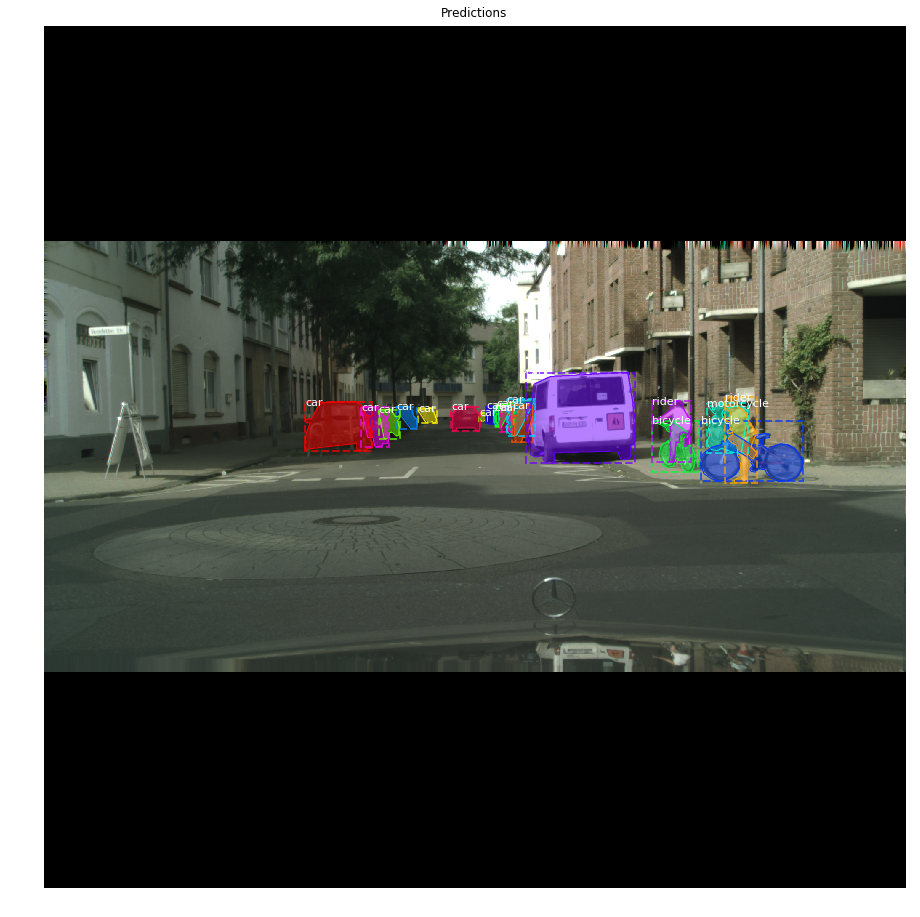

In [10]:


# NOTE shangyin: changed model.py fun: load_image_gt to enable use_mini_mask=False
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]

# gt_mask from True False to 1 0
gt_mask = gt_mask*1

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
# out model
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_train.class_names, r['scores'], ax=ax,
#                             title="Predictions")
# ground truth
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, ax=ax,
                            title="Predictions", save_flag=True)

# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

## confusion matrix

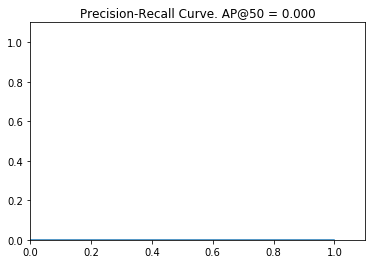

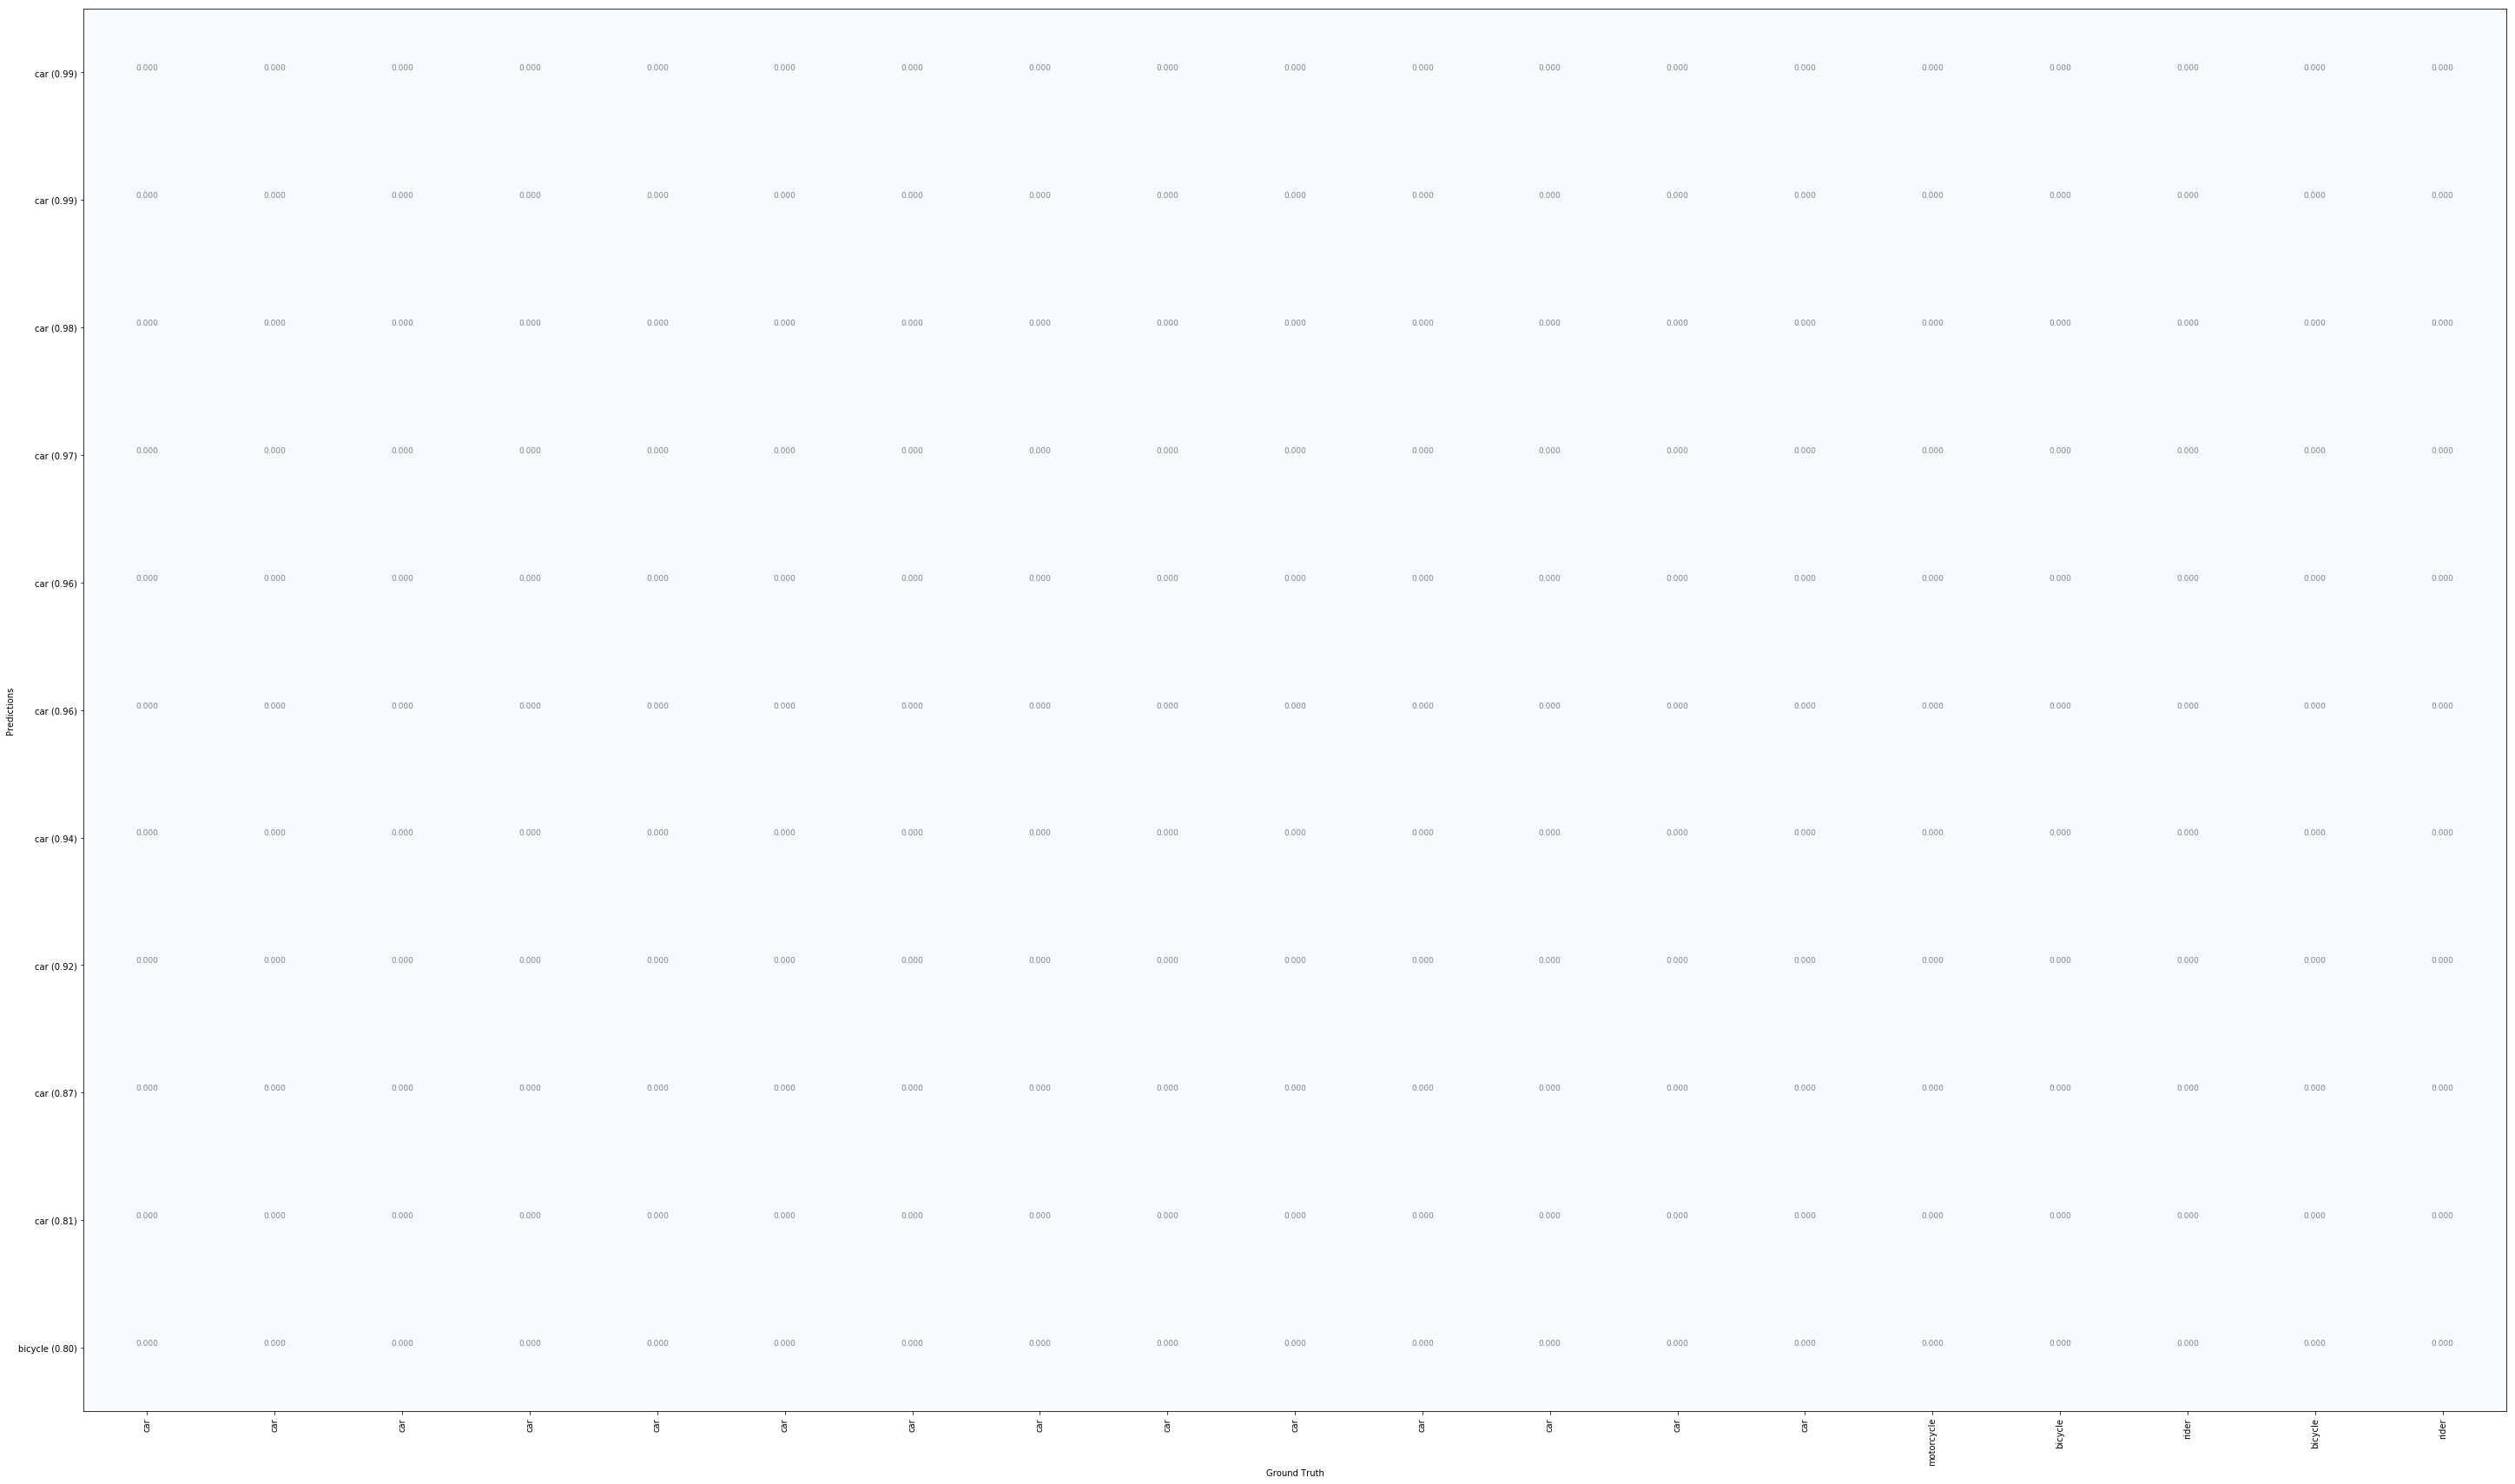

In [14]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_train.class_names, save=True)

## Run Object Detection (our model)

In [16]:
dataset_train.image_info[image_id]['path']

'/home/xiao/shangyin/cityscapes-dataset/images/train/krefeld/krefeld_000000_000926_leftImg8bit.png'

Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 2048, 2048, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 43)               min:    0.00000  max: 2048.00000


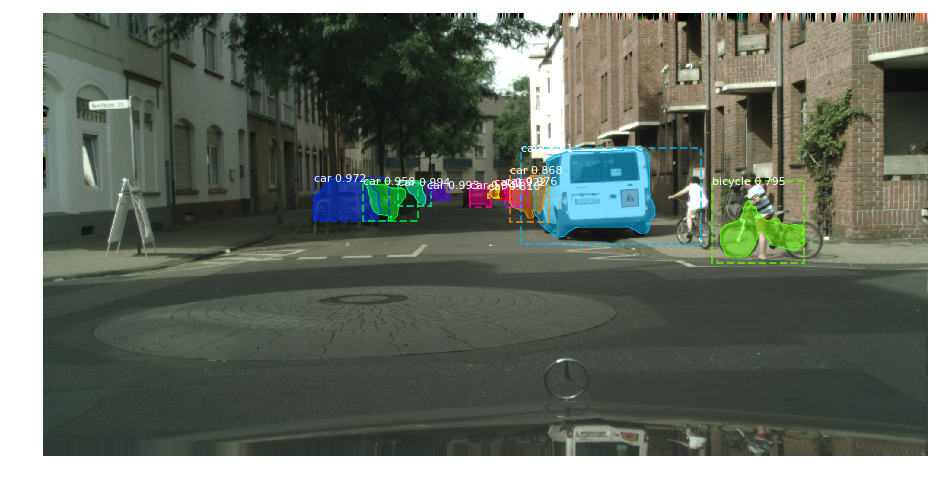

In [12]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# 
image = skimage.io.imread(dataset_train.image_info[image_id]['path'])

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], save_flag=True)

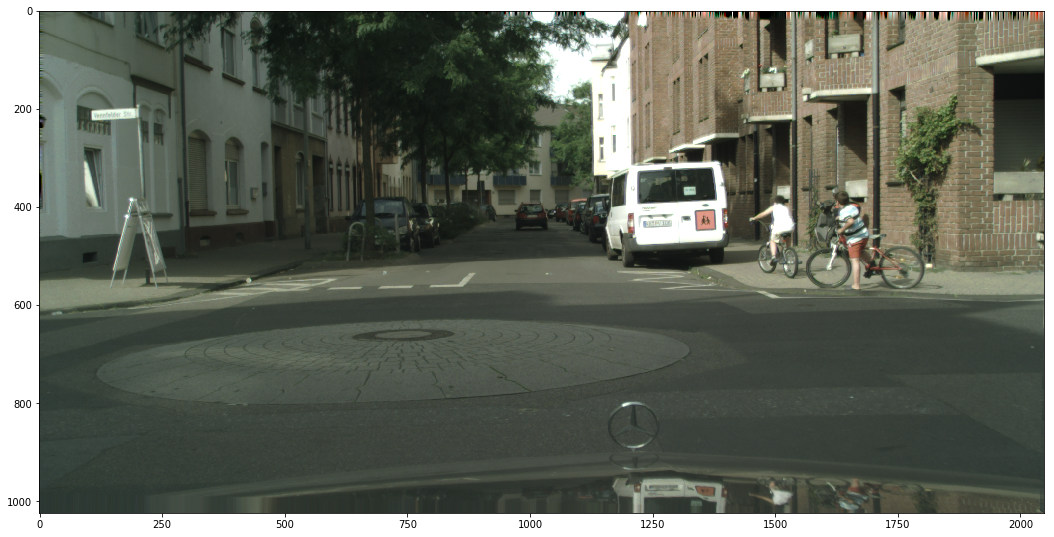

In [19]:
plt.subplots(figsize=(18, 10))
plt.imshow(image)

## Run Detection (origianl model)

In localhost Mask_RCNN/